# Basic web scraping and analysis
This script will extract the table information from a wikipedia link and house the information in a data frame for later processing.

In [1]:
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [2]:
url = r'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
    
df = pd.DataFrame(columns = ['Postal Code', 'Borough', 'Neighbourhood'])

### Part 1: Web data extraction to data frame

In [3]:
res = requests.get(url).text
soup = BeautifulSoup(res,'lxml')
nulCase = 'Not assigned'
skipRow = False
for items in soup.find('table', class_='wikitable').find_all('tr')[1::1]:
    data = items.find_all(['th','td'])
    postCode = data[0].text[0:-1]
    borough = data[1].text[0:-1]
    neighbourhood = data[2].text[0:-1]

    if borough == nulCase:
        skipRow = True

    if neighbourhood == nulCase and borough != nulCase:
        neighborhood = borough

    newRow = {'Postal Code' : postCode, 'Borough' : borough, 'Neighbourhood' : neighbourhood}
    
    if skipRow == False:
        df = df.append(newRow, ignore_index = True)
    skipRow = False

In [4]:
df.head(15)

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
5,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [5]:
df.shape

(103, 3)

### Part 2: Merging Neighborhood data with location data

In [6]:
locationDF = pd.read_csv(r'./Geospatial_Coordinates.csv')
locationDF.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


Postal code is a common column between the two dataframes above, create a new dataframe that is a union of the two based on the postal code

In [7]:
mergedDF = pd.merge(left = df, right = locationDF, left_on = 'Postal Code', right_on = 'Postal Code')
mergedDF.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


### Part 3: Location Clustering

In [8]:
try:
    from geopy.geocoders import Nominatim
except: #install package if it already does not exist
    !conda install -c conda-forge geopy --yes
    from geopy.geocoders import Nominatim
        
try:
    import folium # plotting library
except:
    !conda install -c conda-forge folium=0.5.0 --yes
    import folium # plotting library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

For security purposes, the foursquare API credentials are saved in a separate file

In [9]:
# import data from user file here
file = open('./userCredentials.txt', 'r')
data = file.readlines()

idx = 0
userInfo = []

for line in data:
    values = line.split(':')[-1]
    if values[-1] is '\n':
        userInfo.append(values[1:-1])
    else:
        userInfo.append(values[1:])
    idx += 1

functions to get venues in a given neighbourhood and also the most common ones

In [10]:
def getNearbyVenues(names, latitudes, longitudes, userInfo, radius=500, LIMIT = 30):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            userInfo[0], 
            userInfo[1], 
            userInfo[2], 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

def return_most_common_venues(row, num_top_venues = 5):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Find venues in North York

In [11]:
nbDF = mergedDF[mergedDF['Borough'] == 'North York']
nbDF = nbDF[['Neighbourhood', 'Latitude', 'Longitude']]


venues = getNearbyVenues(names=nbDF['Neighbourhood'],
                                   latitudes=nbDF['Latitude'],
                                   longitudes=nbDF['Longitude'], userInfo = userInfo )

Parkwoods
Victoria Village
Lawrence Manor, Lawrence Heights
Don Mills
Glencairn
Don Mills
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Fairview, Henry Farm, Oriole
Northwood Park, York University
Bayview Village
Downsview
York Mills, Silver Hills
Downsview
North Park, Maple Leaf Park, Upwood Park
Humber Summit
Willowdale, Newtonbrook
Downsview
Bedford Park, Lawrence Manor East
Humberlea, Emery
Willowdale, Willowdale East
Downsview
York Mills West
Willowdale, Willowdale West


Count the venue categories and normalize by the total venues in the neighbourhood

In [12]:
venues.groupby('Neighborhood').count()
# one hot encoding
oneHot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
oneHot['Neighborhood'] = venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [oneHot.columns[-1]] + list(oneHot.columns[:-1])
oneHot = oneHot[fixed_columns]

groupedDF = oneHot.groupby('Neighborhood').mean().reset_index()
groupedDF.head(20)

,Neighborhood,Accessories Store,Airport,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Bakery,Bank,...,Smoke Shop,Snack Place,Sporting Goods Shop,Steakhouse,Supermarket,Sushi Restaurant,Thai Restaurant,Theater,Toy / Game Store,Vietnamese Restaurant
0,"Bathurst Manor, Wilson Heights, Downsview North",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,...,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.000000,0.000000,0.000000
1,Bayview Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,"Bedford Park, Lawrence Manor East",0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.045455,0.045455,0.000000,0.045455,0.000000
3,Don Mills,0.000000,0.000000,0.000000,0.037037,0.000000,0.037037,0.037037,0.000000,0.000000,...,0.037037,0.000000,0.037037,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000
4,Downsview,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.066667,0.000000,0.066667,...,0.000000,0.066667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,"Fairview, Henry Farm, Oriole",0.000000,0.000000,0.033333,0.000000,0.000000,0.000000,0.000000,0.033333,0.066667,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.033333,0.000000
6,Glencairn,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,0.000000
7,Hillcrest Village,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Humber Summit,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,"Humberlea, Emery",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Select the top 5 venues in a given neighbourhood

In [13]:
columns = ['Neighborhood']
num_top_venues = 5
indicators = ['st', 'nd', 'rd']


for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
venuesSorted = pd.DataFrame(columns=columns)
venuesSorted['Neighborhood'] = groupedDF['Neighborhood']

for ind in np.arange(groupedDF.shape[0]):
    venuesSorted.iloc[ind, 1:] = return_most_common_venues(groupedDF.iloc[ind, :], num_top_venues)

venuesSorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Middle Eastern Restaurant,Gas Station,Mobile Phone Shop
1,Bayview Village,Chinese Restaurant,Café,Bank,Japanese Restaurant,Diner
2,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Butcher,Restaurant
3,Don Mills,Gym,Japanese Restaurant,Restaurant,Coffee Shop,Beer Store
4,Downsview,Grocery Store,Park,Baseball Field,Airport,Liquor Store


Cluster neighbourhoods based on their most common venue

In [14]:
# compile data frame of venues for clustering here
clusterCount = num_top_venues
DFForClustering = groupedDF.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=clusterCount, random_state=0).fit(DFForClustering)

venuesSorted.insert(0, 'Cluster Labels', kmeans.labels_)

venueMergedDF = nbDF

# merge clustered data with the main data frame
venueMergedDF = venueMergedDF.join(venuesSorted.set_index('Neighborhood'), on='Neighbourhood')
# some clusters are unlabelled, remove these
venueMergedDF.dropna(subset = ['Cluster Labels'], inplace = True)

Plot cluster data on a map. Map pins are colored for different clusters

In [15]:
address = 'Toronto, Ontario'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)

map_clusters = folium.Map(location=[location.latitude, location.longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterCount)
ys = [i + x + (i*x)**2 for i in range(clusterCount)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(venueMergedDF['Latitude'], venueMergedDF['Longitude'], venueMergedDF['Neighbourhood'], venueMergedDF['Cluster Labels']):
    cluster = int(cluster)
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In case the map does not load, here is the output

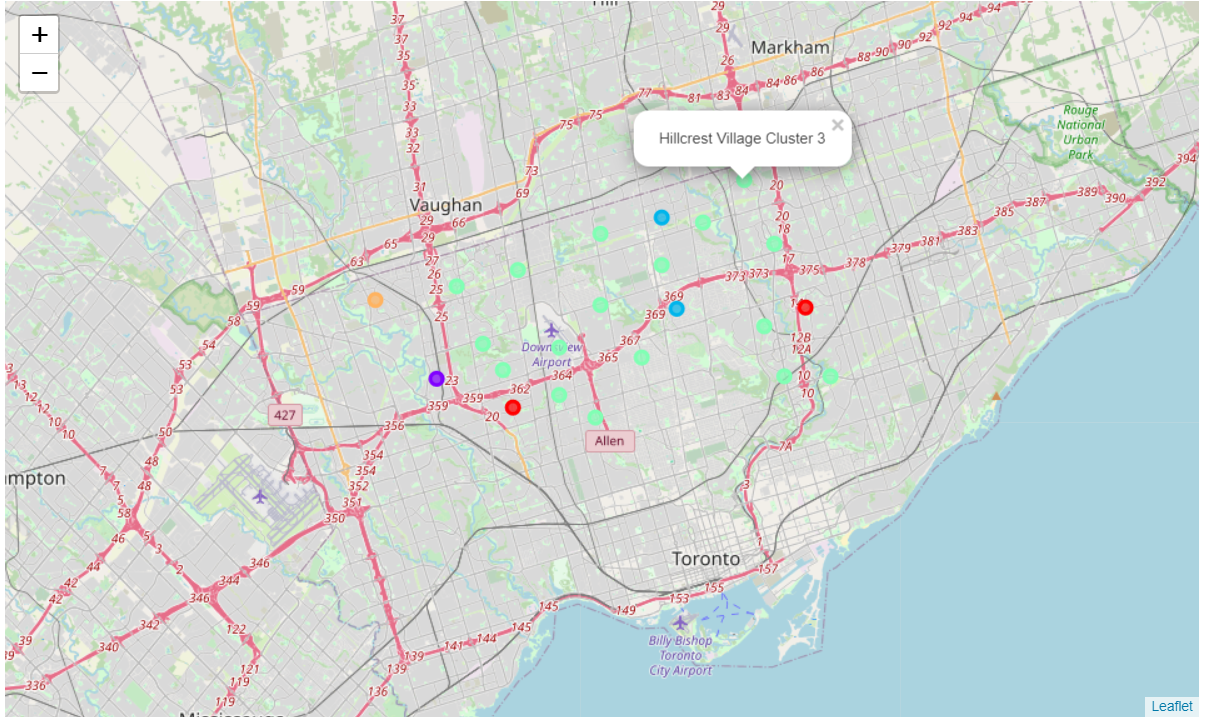